In [564]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
import os
import glob

temp = pd.read_excel(os.path.expanduser("/Users/seanlow/Desktop/QF603/603 Project/Project_603.xlsx"), index_col=0)
sample = temp[temp.Team==6]; #print(sample)

path = '/Users/seanlow/Desktop/QF603/603 Project/2018'
os.chdir(path)

Data = pd.DataFrame()
Annual_returns = pd.DataFrame()
DataR = pd.DataFrame()
AnnualR = pd.DataFrame()

for i in sample.index:
    temp = pd.read_csv(i, header=0, index_col=0,parse_dates=True)
    Data[i] = temp[temp.index>'1999-04-01']["Adj Close"].resample('M').agg({'Adj Close':'last'}).pct_change()
    Annual_returns[i] = temp[temp.index>'1999-04-01']["Adj Close"].resample('Y').agg({'Adj Close':'last'}).pct_change()

for i in sample.index:
    temp = pd.read_csv(i, header=0, index_col=0,parse_dates=True)
    DataR[i] = temp[temp.index>'1999-04-01']["Adj Close"].resample('M').agg({'Adj Close':'last'})
    AnnualR[i] = temp[temp.index>'1999-04-01']["Adj Close"].resample('Y').agg({'Adj Close':'last'})

Data=Data.drop(Data.index[0])
Annual_returns=Annual_returns.drop(Annual_returns.index[0])


In [565]:
path = '/Users/seanlow/Desktop/QF603/603 Project'
os.chdir(path)
FF_factors = pd.read_csv('FF.csv', header=0, index_col=0)
SNP500 = pd.read_csv('^GSPC.csv', header=0, index_col=0, parse_dates=True)

In [566]:
Rf = (np.array([FF_factors.iloc[:,3].values]).T)/100
Ri_Rf = Data-Rf
Rm = SNP500[SNP500.index>'1999-04-01']["Adj Close"].resample('M').agg({'Adj Close':'last'}).pct_change()
Rm = pd.DataFrame(Rm.drop(Rm.index[0]))
Rm_Rf = Rm-Rf
Rm_Rf_df = pd.DataFrame(np.repeat(Rm_Rf.values,100,axis=1))

Regression = LinearRegression()
Regression.fit(Rm_Rf_df,Ri_Rf)

beta=pd.DataFrame(Regression.coef_)
alpha = pd.DataFrame(Regression.intercept_, columns=['alphas'])
alpha.index=Ri_Rf.columns

sort_alpha = alpha.sort_values('alphas', ascending=False)
sort_alpha.to_csv('/Users/seanlow/Desktop/QF603/603 Project/Sort_alphas.csv')

select = np.append(sort_alpha.index[0:10].values, sort_alpha.index[90:].values)

selected = Data[select]
selected_annual = Annual_returns[select]
selected_annual = selected_annual.T
selected_annual.columns=[str(x) for x in range(2000,2019)]
#print(selected_annual)
#pd.DataFrame(selected.columns).to_csv('selected.csv')

Returns: 0.024653979125670928
Stdev: 0.06763251241133235
Sharpe 0.3645285122002944
0
3050.csv    0.060336
2029.csv    0.078016
1172.csv    0.071199
1992.csv    0.079771
3030.csv    0.074707
0221.csv    0.243698
0824.csv    0.072659
2797.csv    0.171570
3005.csv    0.061880
2135.csv    0.086165
0589.csv   -0.030973
2319.csv   -0.048799
0602.csv   -0.107769
0297.csv   -0.037639
0060.csv   -0.309899
1420.csv   -0.018798
0516.csv   -0.049150
3806.csv   -0.045330
2058.csv   -0.335081
3702.csv   -0.016561
Name: 65127, dtype: float64


Text(0, 0.5, 'Returns')

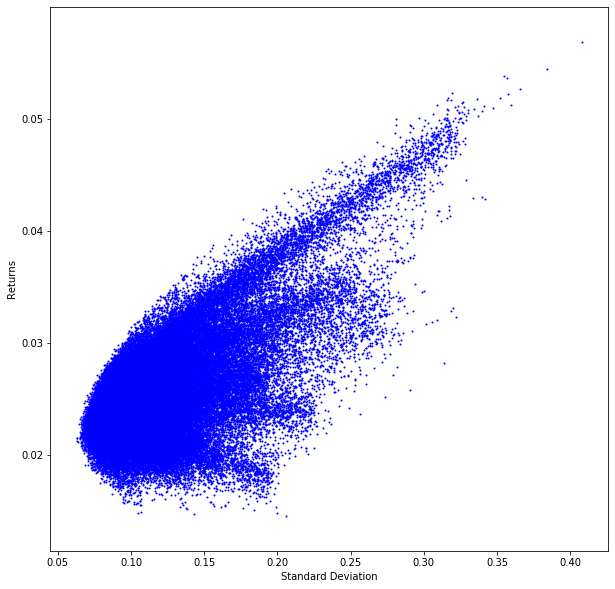

In [437]:
#Modify mean and covariance variables here

mean_returns=selected.mean()
cov_matrix = selected.cov()

#Set the number of iterations to 100000 (I set to 200 just to test). Change "Data.columns" to suit your code
num_iterations = 100000
simulation_res = np.zeros((4+len(selected.columns)-1,num_iterations))

for i in range(num_iterations):
#Select random weights and normalize to set the sum to 1 (change number inside "rand()", should be number of stocks in covariance)
        wp = np.array(np.random.rand(10))
        weightspositive = 1/wp
        weightspositive /= np.sum(weightspositive)
        
        wn = np.array(np.random.rand(10))
        weightsnegative = 1/wn
        weightsnegative /= -np.sum(weightsnegative)
        
        weights = np.concatenate((weightspositive, weightsnegative))
        
        
#Calculate the return and standard deviation for every step
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
        
#Store all the results in a defined array
        simulation_res[0,i] = portfolio_return
        simulation_res[1,i] = portfolio_std_dev


#Calculate Sharpe ratio and store it in the array
        simulation_res[2,i] = simulation_res[0,i] / simulation_res[1,i]
    
       #Save the weights in the array
        for j in range(len(weights)):
              simulation_res[j+3,i] = weights[j]

#Create an Index for Simulation output
indexlst=[]
indexlst.append('Returns')
indexlst.append('Stdev')
indexlst.append('Sharpe')

for i in selected.columns:
    indexlst.append(i)

index_df=pd.DataFrame(indexlst)

simulation = pd.DataFrame(simulation_res)
simulation.index = index_df.iloc[:,0]

#Print and export this to get the Returns, Stdev, Sharpe and Weights of all iterations
#print(pd.DataFrame(simulation.T))
sort_sharpe = (simulation.T).sort_values('Sharpe', ascending=False)
sort_sharpe.to_csv('simulation_results.csv')

#####Prints "Optimal" portfolio#######
print('Returns:',sort_sharpe.iloc[0,0])
print('Stdev:', sort_sharpe.iloc[0,1])
print('Sharpe', sort_sharpe.iloc[0,2])
print(sort_sharpe.iloc[0,3:])
sort_sharpe.iloc[0,3:].to_csv("weights.csv", header=0)

#Create a scatter plot coloured by various Sharpe Ratios with standard deviation on the x-axis and returns on the y-axis
sim_frame = pd.DataFrame(simulation_res.T)
ret = sim_frame[0]
stdev = sim_frame[1]

plt.figure(figsize=(10,10))
plt.scatter(stdev,ret,s=1,c='b')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

In [507]:
weights = sort_sharpe.iloc[0,3:]
weightnp = np.zeros((len(selected_annual.index),len(selected_annual.columns)))
for i in range(0,19):
    weightnp[:,i]= weights
    
annual_weighted_returns=weightnp*selected_annual
annual_weighted_returns


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
3050.csv,-0.052466,0.095196,-0.009154,0.062788,-0.049518,0.150169,-0.021521,-0.037038,-0.049506,0.663691,0.374224,0.011967,-0.033621,0.051313,-0.026714,0.014583,0.029948,0.027470,0.012539
2029.csv,-0.026005,-0.036277,0.119575,0.046349,-0.010474,0.043806,0.051031,0.092714,-0.065985,0.111998,0.028887,0.024236,-0.005252,0.079247,0.028547,0.022966,-0.022302,-0.004840,0.020223
1172.csv,0.030259,0.063504,0.257541,-0.030429,0.049384,0.064735,0.048438,0.004839,0.016168,-0.004298,0.029227,0.036734,-0.009742,0.006407,-0.014142,-0.009483,0.023932,-0.001855,-0.006371
1992.csv,0.020681,-0.014077,0.047407,0.154681,0.039892,0.019084,0.024696,0.024494,-0.009134,-0.009740,0.005369,0.010113,0.024808,0.048334,0.008384,-0.006170,0.029750,0.004189,0.019918
3030.csv,-0.048444,-0.024875,-0.013440,0.133025,-0.027238,0.012953,-0.014600,-0.050100,-0.062614,0.496385,-0.006515,0.026171,0.071888,0.176441,-0.025828,0.006654,-0.020354,0.035705,-0.029353
0221.csv,-0.002984,0.384922,-0.106999,0.212547,0.161395,0.051284,0.062077,0.176130,-0.101910,0.069668,0.032895,0.001308,-0.030595,0.170825,0.034358,0.229260,-0.014518,0.186250,-0.063541
0824.csv,-0.013966,0.060167,0.278969,-0.011382,-0.008879,0.067112,0.003154,-0.010492,0.045735,-0.002624,0.012106,0.017719,0.015699,-0.030738,0.027507,-0.029896,0.055723,0.022759,0.004021
2797.csv,0.020185,0.094755,0.115414,-0.007419,0.443989,0.029957,-0.025752,0.011107,-0.136433,0.052275,0.009246,0.070188,0.080251,0.124436,-0.043166,0.043805,0.075607,0.005046,0.137256
3005.csv,-0.022502,0.024163,0.009324,0.129654,0.012947,-0.018265,0.271648,0.000425,-0.024987,0.003763,-0.032429,0.002769,-0.013744,0.040258,0.046742,-0.018047,0.009449,-0.038320,0.009060
2135.csv,0.018004,0.096768,0.044647,0.063746,0.044811,0.031774,-0.005156,0.038850,-0.029020,0.029501,0.050619,0.027104,-0.011762,0.049864,-0.032954,-0.030977,0.057191,0.033338,0.005855


In [532]:
SNP_Annual= SNP500[SNP500.index>'1999-04-01']["Adj Close"].resample('Y').agg({'Adj Close':'last'}).pct_change()
SNP_Annual=pd.DataFrame(SNP_Annual.drop(SNP_Annual.index[0]))
SNP_Annual=SNP_Annual.T
SNP_Annual


Adj Close                                                         \
Date      2000-12-31 2001-12-31 2002-12-31 2003-12-31 2004-12-31 2005-12-31   
Adj Close  -0.101392  -0.130427   -0.23366   0.263804   0.089935    0.03001   

                                                                             \
Date      2006-12-31 2007-12-31 2008-12-31 2009-12-31 2010-12-31 2011-12-31   
Adj Close   0.136194   0.035296  -0.384858   0.234542   0.127827  -0.000032   

                                                                             \
Date      2012-12-31 2013-12-31 2014-12-31 2015-12-31 2016-12-31 2017-12-31   
Adj Close   0.134057   0.296012   0.113906  -0.007266    0.09535     0.1942   

                      
Date      2018-12-31  
Adj Close  -0.062373

In [552]:
AnnualR

3237.csv   1704.csv   1124.csv   0279.csv   2029.csv  \
          Date                                                                
Adj Close 1999-12-31  17.375000  31.256594   4.898491   9.483044   3.000000   
          2000-12-31  10.750000  17.041147   3.915219   6.625330   2.000000   
          2001-12-31  15.960000  13.289777   6.335858   7.939519   1.070000   
          2002-12-31  18.959999   6.732992   6.493181   8.775196   2.710000   
          2003-12-31  19.010000  10.479727  10.083029   9.144612   4.320000   
          2004-12-31  20.820000   8.986596  16.884823  13.486581   3.740000   
          2005-12-31  13.980000  11.175282  24.682018  19.256338   5.840000   
          2006-12-31  11.400000  22.146532  25.175301  31.643055   9.660000   
          2007-12-31   6.720000  19.726000  20.170631  32.327816  21.139999   
          2008-12-31   2.000000   7.743869  18.811934  25.788662   3.260000   
          2009-12-31   4.210000  18.576015  20.332355  41.421516   7.940000   
          2010-12-31   9.680000  19.095358  25.103519  48.993465  10.880000   
          2011-12-31   2.970000  15.024033  25.497768  62.087780  14.260000   
          2012-12-31   5.530000  16.507889  30.460447  91.154144  13.300000   
          2013-12-31   8.210000  22.202183  45.266075  91.465630  26.809999   
          2014-12-31  27.110001  21.961056  52.591217  82.269524  36.619999   
          2015-12-31  18.889999  26.248466  48.027428  87.555435  47.400002   
          2016-12-31  19.340000  29.077414  54.305763  73.291283  33.849998   
          2017-12-31  28.730000  38.893593  76.154068  91.699364  31.750000   
          2018-12-31  19.200001  28.144159  71.033562  85.379669  39.980000   

                        0693.csv   1331.csv   0427.csv   1223.csv  \
          Date                                                      
Adj Close 1999-12-31   16.259111   1.367714  10.672491   9.725324   
          2000-12-31   52.535431   0.920331  10.312458  13.257632   
          2001-12-31   52.076054   2.675095   7.652511  14.496230   
          2002-12-31   40.946793   2.523752   5.344919  13.028260   
          2003-12-31   62.980282   4.346008   9.256670  20.273027   
          2004-12-31   67.008202   6.294427  10.853494  26.813316   
          2005-12-31   75.434998   7.554802  14.439594  30.382654   
          2006-12-31   74.212440   9.302446  18.540585  29.936016   
          2007-12-31   77.404175  11.138639  22.291826  31.382784   
          2008-12-31   60.112499  10.394636  20.249161  29.130276   
          2009-12-31   69.418953  12.780893  23.206470  37.983952   
          2010-12-31   70.393181  16.037832  25.669443  53.132488   
          2011-12-31   71.398911  17.503935  30.642265  59.565628   
          2012-12-31   95.178162  19.030230  31.334238  63.940483   
          2013-12-31  137.083313  22.264666  32.964409  69.429626   
          2014-12-31  152.766876  25.156168  34.961536  71.144112   
          2015-12-31  167.913620  25.508904  39.789082  50.440372   
          2016-12-31  203.361267  24.633646  40.551693  85.328285   
          2017-12-31  212.375046  28.636030  51.048653  91.677307   
          2018-12-31  213.914810  23.354639  31.855471  74.932899   

                         2058.csv  ...   0052.csv   0426.csv   0317.csv  \
          Date                     ...                                    
Adj Close 1999-12-31  1283.710693  ...   1.819198   6.125101  13.395041   
          2000-12-31   954.995178  ...   2.523843  13.730154  10.623576   
          2001-12-31   596.324036  ...   2.882228  17.778879  11.036994   
          2002-12-31   400.449707  ...   2.097372  19.630760  11.826593   
          2003-12-31   554.877563  ...   3.019453  40.419914  19.358402   
          2004-12-31   667.925415  ...   4.065175  48.288021  23.666641   
          2005-12-31   694.825623  ...   4.279324  52.510513  24.546785   
          2006-12-31   700.471497  ...   6.463860  45.725838  24.310722   
          2007-

In [563]:
(pd.DataFrame(AnnualR[select]).T).to_csv("ActualStockValues.csv")

In [560]:
AnnualSNP = SNP500[SNP500.index>'1999-04-01']["Adj Close"].resample('Y').agg({'Adj Close':'last'})
(pd.DataFrame(AnnualSNP).T).to_csv("ActualSNP.csv")

In [569]:
for i in sample.index:
    temp = pd.read_csv(i, header=0, index_col=0,parse_dates=True)
    DataR[i] = temp[temp.index>'1999-04-01']["Adj Close"].resample('M').agg({'Adj Close':'last'})
    AnnualR[i] = temp[temp.index>'1999-04-01']["Adj Close"].resample('Y').agg({'Adj Close':'last'})
AnnualR[select]

3050.csv   2029.csv   1172.csv   1992.csv   3030.csv  \
          Date                                                               
Adj Close 1999-12-31    4.3125   3.000000   0.625000   1.110967  26.312500   
          2000-12-31    0.5625   2.000000   0.890625   1.398996   9.250000   
          2001-12-31    1.4500   1.070000   1.685000   1.152114   6.170000   
          2002-12-31    1.2300   2.710000   7.780000   1.836800   5.060000   
          2003-12-31    2.5100   4.320000   4.455000   5.398478  14.070000   
          2004-12-31    0.4500   3.740000   7.545000   8.098155   8.940000   
          2005-12-31    1.5700   5.840000  14.405000  10.035539  10.490000   
          2006-12-31    1.0100   9.660000  24.205000  13.142361   8.440000   
          2007-12-31    0.3900  21.139999  25.850000  17.177837   2.780000   
          2008-12-31    0.0700   3.260000  31.719999  15.210867   0.450000   
          2009-12-31    0.8400   7.940000  29.805000  13.353630   3.440000   
          2010-12-31    6.0500  10.880000  42.040001  14.252356   3.140000   
          2011-12-31    7.2500  14.260000  63.730000  16.059122   4.240000   
          2012-12-31    3.2100  13.300000  55.009998  21.053282   8.320000   
          2013-12-31    5.9400  26.809999  59.959999  33.809692  27.969999   
          2014-12-31    3.3100  36.619999  48.049999  37.363194  18.299999   
          2015-12-31    4.1100  47.400002  41.650002  34.473289  19.930000   
          2016-12-31    6.1500  33.849998  55.650002  47.329872  14.500000   
          2017-12-31    8.9500  31.750000  54.200001  49.815411  21.430000   
          2018-12-31   10.8100  39.980000  49.349998  62.253670  13.010000   

                       0221.csv   0824.csv   2797.csv   3005.csv   2135.csv  \
          Date                                                                
Adj Close 1999-12-31   1.151060   2.935818   0.590278   4.125000   0.750920   
          2000-12-31   1.136966   2.371526   0.659722   2.625000   0.907821   
          2001-12-31   2.932808   4.335310   1.024074   3.650000   1.927351   
          2002-12-31   1.645123  20.980377   1.712963   4.200000   2.926019   
          2003-12-31   3.079955  17.693789   1.638889  13.000000   5.090717   
          2004-12-31   5.119728  15.531533   5.880000  15.720000   7.738180   
          2005-12-31   6.197120  29.877398   6.906667  11.080000  10.591692   
          2006-12-31   7.775716  31.174297   5.870000  59.720001   9.957870   
          2007-12-31  13.395522  26.672745   6.250000  60.130001  14.447645   
          2008-12-31   7.793759  43.461693   1.280000  35.849998   9.581678   
          2009-12-31  10.021834  41.891850   1.670000  38.029999  12.862284   
          2010-12-31  11.374589  48.871311   1.760000  18.100000  20.418486   
          2011-12-31  11.435625  60.789463   2.480000  18.910000  26.841354   
          2012-12-31   9.999950  73.923637   3.640000  14.710000  23.177382   
          2013-12-31  17.009592  42.650566   6.280000  24.280001  36.590317   
          2014-12-31  19.407677  58.796780   4.700000  42.619999  22.596041   
          2015-12-31  37.665562  34.604874   5.900000  30.190001  14.472602   
          2016-12-31  35.421642  61.143681   8.500000  34.799999  24.078659   
          2017-12-31  62.493229  80.295296   8.750000  13.250000  33.394890   
          2018-12-31  46.198887  84.739418  15.750000  15.190000  35.664051   

                       0589.csv   2319.csv   0602.csv   0297.csv    0060.csv  \
          Date                                                                 
Adj Close 1999-12-31  13.952435  21.161734  23.238817  42.101109   71.898468   
          2000-12-31  14.476216  32.279308  23.126915  39.674011   56.916203   
          2001-12-31  14.128062  28.461000  17.409346  40.472622   81.392929   
          2002-12-31  12.419598  27.295572  15.278685  37.735859   52.532738   
          2003-12-31  16.601171  25.780514  14.383445  48.812870   63.300930   
      